# Stacking and Blending in Machine Learning

In this notebook, we explore *meta-ensembling* techniques:
- **Stacking:** Using multiple base learners and a meta-learner.
- **Blending:** Using a hold-out validation set to combine models.

We'll demonstrate both classification and regression examples using:
- Base models: Logistic Regression, RandomForest, XGBoost
- Meta-model: Linear Regression or Logistic Regression


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import StackingClassifier, StackingRegressor

import warnings
warnings.filterwarnings('ignore')

# Classification Stacking

In [8]:
# Data
X, y = make_classification(n_samples=2000, n_features=10, n_informative=6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base models
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=100, random_state=42))
]

# Meta-model
meta_model = LogisticRegression()

# Stacking ensemble
stack_model = StackingClassifier(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)
stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)
print(f"StackingClassifier Accuracy: {accuracy_score(y_test, y_pred):.3f}")


StackingClassifier Accuracy: 0.917


# Regression Stacking

In [9]:
# Data
X, y = make_regression(n_samples=2000, n_features=10, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Base models
base_learners = [
    ('lr', LinearRegression()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('xgb', XGBRegressor(n_estimators=100, random_state=42))
]

# Meta-model
meta_model = LinearRegression()

# Stacking
stack_model = StackingRegressor(estimators=base_learners, final_estimator=meta_model, cv=5, n_jobs=-1)
stack_model.fit(X_train, y_train)

y_pred = stack_model.predict(X_test)
print(f"StackingRegressor RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f}")


StackingRegressor RMSE: 0.196


# Blending Implementation

In [10]:
# Split the data into training and testing
X, y = make_regression(n_samples=2000, n_features=10, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split data for blending: train → (train_base, holdout)
X_train_base, X_blend, y_train_base, y_blend = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Base models
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)
lr = LinearRegression()

# Train base models on base set
rf.fit(X_train_base, y_train_base)
xgb.fit(X_train_base, y_train_base)
lr.fit(X_train_base, y_train_base)

# Generate holdout predictions
blend_features = np.column_stack([
    rf.predict(X_blend),
    xgb.predict(X_blend),
    lr.predict(X_blend)
])

# Train meta-model on holdout predictions
meta_model = LinearRegression()
meta_model.fit(blend_features, y_blend)

# Predict on test set
test_features = np.column_stack([
    rf.predict(X_test),
    xgb.predict(X_test),
    lr.predict(X_test)
])

y_pred_blend = meta_model.predict(test_features)
rmse_blend = mean_squared_error(y_test, y_pred_blend, squared=False)
print(f"Blending RMSE: {rmse_blend:.3f}")

Blending RMSE: 0.196


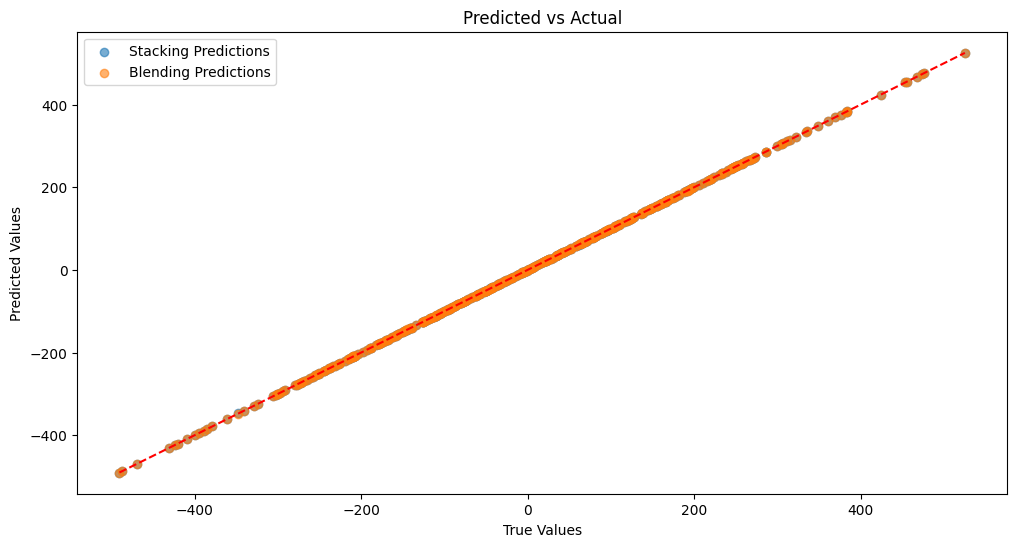

In [13]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Stacking Predictions')
plt.scatter(y_test, y_pred_blend, alpha=0.6, label='Blending Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title("Predicted vs Actual")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.show()

## Key Takeaways

| Method | How It Works | Pros | Cons |
|--------|---------------|------|------|
| **Stacking** | Meta-model learns from out-of-fold predictions of base models | Uses cross-validation → robust | Slightly slower |
| **Blending** | Meta-model trained on a validation (holdout) set | Simple, easy to implement | Can overfit or underfit depending on split |

**When to use:**
- Use **stacking** when you have enough data and want robustness.
- Use **blending** for fast experimentation or competitions (Kaggle-style).
